# Performance Metrics Analysis for Imbalanced Datasets

This notebook addresses the reviewer's question:
> Author mention precision and recall as valuable metrics for handling imbalanced data. Could you provide more experimental data showing how selecting different performance metrics (such as accuracy, recall, F1 score, etc.) affects model results? How do these metrics influence model optimization in practical applications?

We will use the chlorine detection dataset with **artificially created 1000:1 class imbalance** to demonstrate:
1. **Impact of different performance metrics** on model evaluation 
2. **Metric behavior with extreme class imbalance** (1000:1 ratio)
3. **Model optimization effects** when using different metrics as objectives
4. **Practical implications** for analytical chemistry applications  
5. **Threshold optimization** for different metrics
6. **Cost-sensitive considerations** in mass spectrometry applications

**Key Point**: We create an extreme 1000:1 imbalanced dataset to dramatically show why accuracy alone is completely inadequate and how different metrics lead to vastly different model behavior in real-world scenarios.

In [1]:
# Import required libraries
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV, cross_validate
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, matthews_corrcoef,
    classification_report, confusion_matrix, roc_curve, 
    precision_recall_curve, make_scorer
)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

print("✓ Libraries imported successfully")
print("✓ Environment configured for performance metrics analysis")

/home/chen/miniconda3/lib/python3.11/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "PWD" redefined by R and overriding existing variable. Current: "/home/chen", R: "/home/chen/proj/ml_tutorial_paper/ML4MassSpec"
  warnings.warn(
/home/chen/miniconda3/lib/python3.11/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "LD_LIBRARY_PATH" redefined by R and overriding existing variable. Current: "/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/home/chen/miniconda3/lib/jvm/lib/server", R: "/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/home/chen/miniconda3/lib/jvm/lib/server:/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/home/chen/miniconda3/lib/jvm/lib/server"
  warnings.warn(
/home/chen/miniconda3/lib/python3.11/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "R_LIBS_SITE" redefined by R and overriding existing variable. Current: "/usr/local/lib/R/site-library/:/usr/local/lib/R/site-library:/usr/lib/R/site-

✓ Libraries imported successfully
✓ Environment configured for performance metrics analysis


## Data Loading and Preprocessing

Loading the same chlorine detection dataset used in the k-fold CV analysis.

In [2]:
# Load data function (copied from kfold_cv notebook)
try:
    print("✓ rpy2 is available (using context-based conversion)")
    def load_rds_file(filepath):
        readRDS = robjects.r['readRDS']
        with localconverter(robjects.default_converter + pandas2ri.converter):
            r_data = readRDS(filepath)
            return r_data
    RDS_AVAILABLE = True
except Exception as e:
    print(f"Using fallback rpy2 method: {e}")
    pandas2ri.activate()
    def load_rds_file(filepath):
        readRDS = robjects.r['readRDS']
        r_data = readRDS(filepath)
        return r_data
    RDS_AVAILABLE = True
    print("✓ rpy2 is available (using legacy activation)")

DATA_PATHS = {
    'non_cl_full': '/data/chen/data/chlorine_tingting/968442_non_cl_filter_S10.rds',
    'cl_full': '/data/chen/data/chlorine_tingting/386420_cl_data.rds',
    'train': '/data/chen/data/chlorine_tingting/80%_618272_train_binary.rds',
    'test': '/data/chen/data/chlorine_tingting/20%_154568_test_binary.rds'
}

def load_actual_chlorine_data():
    """Load the actual chlorine detection data from .rds files"""
    if not RDS_AVAILABLE:
        print("rpy2 not available, using simulated data...")
        return None, None, None, None

    try:
        print("Loading chlorine detection dataset...")
        train_data = load_rds_file(DATA_PATHS['train'])
        test_data = load_rds_file(DATA_PATHS['test'])
        non_cl_data = load_rds_file(DATA_PATHS['non_cl_full'])
        cl_data = load_rds_file(DATA_PATHS['cl_full'])
        print("✓ Data loading successful!")
        return train_data, test_data, non_cl_data, cl_data
    except Exception as e:
        print(f"Error loading actual data: {e}")
        return None, None, None, None

# Load data
train_data, test_data, non_cl_full, cl_full = load_actual_chlorine_data()

✓ rpy2 is available (using context-based conversion)
Loading chlorine detection dataset...
✓ Data loading successful!


In [3]:
# Data preprocessing and feature selection
if train_data is not None:
    # Prepare training data
    train_dataset = train_data.copy()
    train_dataset['has_chlorine'] = (train_dataset['Cl'].astype(int) > 0).astype(int)
    
    # Prepare test data
    test_dataset = test_data.copy()
    test_dataset['has_chlorine'] = (test_dataset['Cl'].astype(int) > 0).astype(int)
    
    # Feature selection (same as kfold_cv notebook)
    exclude_cols = ['MF', 'Cl', 'has_chlorine']
    all_columns = train_dataset.columns.tolist()
    potential_features = [col for col in all_columns if col not in exclude_cols]
    
    # Select numerical features with low missing value rates
    numerical_features = []
    for col in potential_features:
        if pd.api.types.is_numeric_dtype(train_dataset[col]):
            train_missing_ratio = train_dataset[col].isnull().sum() / len(train_dataset)
            test_missing_ratio = test_dataset[col].isnull().sum() / len(test_dataset)
            if train_missing_ratio < 0.5 and test_missing_ratio < 0.5:
                numerical_features.append(col)
    
    feature_cols = numerical_features
    target_col = 'has_chlorine'
    
    print(f"Original Dataset Analysis:")
    print(f"Training samples: {len(train_dataset):,}")
    print(f"Test samples: {len(test_dataset):,}")
    print(f"Features: {len(feature_cols)}")
    print(f"Target: {target_col}")
    
    # Analyze original class distribution
    print(f"\nOriginal Class Distribution (Training):")
    train_dist = train_dataset[target_col].value_counts().sort_index()
    for class_val, count in train_dist.items():
        label = "No Chlorine" if class_val == 0 else "Has Chlorine"
        percentage = count / len(train_dataset) * 100
        print(f"  {label}: {count:,} ({percentage:.1f}%)")
    
    original_imbalance = train_dist.max() / train_dist.min()
    print(f"Original Imbalance Ratio: {original_imbalance:.1f}:1")
    
    # CREATE 1000:1 IMBALANCED DATASET FOR METRICS ANALYSIS
    print(f"\n" + "="*60)
    print("CREATING 1000:1 IMBALANCED DATASET FOR METRICS ANALYSIS")
    print("="*60)
    
    # Separate classes
    chlorine_samples = train_dataset[train_dataset[target_col] == 1]
    non_chlorine_samples = train_dataset[train_dataset[target_col] == 0]
    
    # Target: 1000:1 ratio (majority:minority)
    # Let's use 100,100 total samples with 100,000 majority + 100 minority
    target_total = 100100
    target_minority = int(target_total / 1001)  # ~100
    target_majority = target_total - target_minority  # ~100,000
    
    print(f"Creating extremely imbalanced dataset:")
    print(f"Target ratio: 1000:1 (majority:minority)")
    print(f"Target total samples: {target_total:,}")
    print(f"Target majority samples: {target_majority:,}")
    print(f"Target minority samples: {target_minority:,}")
    
    # Sample from available data
    available_minority = len(chlorine_samples)
    available_majority = len(non_chlorine_samples)
    
    print(f"\nAvailable samples:")
    print(f"Chlorine samples (minority): {available_minority:,}")
    print(f"Non-chlorine samples (majority): {available_majority:,}")
    
    # Use all available minority samples if we have fewer than target
    actual_minority = min(target_minority, available_minority)
    actual_majority = min(target_majority, available_majority)
    
    # Ensure 1000:1 ratio
    if actual_minority * 1000 > actual_majority:
        actual_minority = actual_majority // 1000
    else:
        actual_majority = actual_minority * 1000
    
    print(f"\nActual sampling:")
    print(f"Minority samples to use: {actual_minority:,}")
    print(f"Majority samples to use: {actual_majority:,}")
    print(f"Actual ratio: {actual_majority/actual_minority:.1f}:1")
    
    # Sample the data
    minority_sampled = chlorine_samples.sample(n=actual_minority, random_state=42)
    majority_sampled = non_chlorine_samples.sample(n=actual_majority, random_state=42)
    
    # Combine and shuffle
    imbalanced_train = pd.concat([majority_sampled, minority_sampled], ignore_index=True)
    imbalanced_train = imbalanced_train.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Create imbalanced test set with same ratio (1000:1)
    test_minority_target = len(test_dataset) // 1001
    test_majority_target = len(test_dataset) - test_minority_target
    
    test_chlorine = test_dataset[test_dataset[target_col] == 1]
    test_non_chlorine = test_dataset[test_dataset[target_col] == 0]
    
    test_minority_actual = min(test_minority_target, len(test_chlorine))
    test_majority_actual = min(test_majority_target, len(test_non_chlorine))
    
    # Ensure 1000:1 ratio for test set too
    if test_minority_actual * 1000 > test_majority_actual:
        test_minority_actual = test_majority_actual // 1000
    else:
        test_majority_actual = test_minority_actual * 1000
    
    test_minority_sampled = test_chlorine.sample(n=test_minority_actual, random_state=42)
    test_majority_sampled = test_non_chlorine.sample(n=test_majority_actual, random_state=42)
    
    imbalanced_test = pd.concat([test_majority_sampled, test_minority_sampled], ignore_index=True)
    imbalanced_test = imbalanced_test.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Update datasets
    train_dataset = imbalanced_train
    test_dataset = imbalanced_test
    
    print(f"\nFinal Extremely Imbalanced Dataset:")
    print(f"Training samples: {len(train_dataset):,}")
    print(f"Test samples: {len(test_dataset):,}")
    
    # Analyze final class distribution
    print(f"\nFinal Class Distribution (Training):")
    train_dist = train_dataset[target_col].value_counts().sort_index()
    for class_val, count in train_dist.items():
        label = "No Chlorine" if class_val == 0 else "Has Chlorine"
        percentage = count / len(train_dataset) * 100
        print(f"  {label}: {count:,} ({percentage:.2f}%)")
    
    print(f"\nFinal Class Distribution (Test):")
    test_dist = test_dataset[target_col].value_counts().sort_index()
    for class_val, count in test_dist.items():
        label = "No Chlorine" if class_val == 0 else "Has Chlorine"
        percentage = count / len(test_dataset) * 100
        print(f"  {label}: {count:,} ({percentage:.2f}%)")
    
    # Calculate final imbalance ratio
    minority_class = train_dist.min()
    majority_class = train_dist.max()
    imbalance_ratio = majority_class / minority_class
    print(f"\nFinal Imbalance Ratio: {imbalance_ratio:.1f}:1 (majority:minority)")
    
    # Prepare datasets for analysis
    X_train = train_dataset[feature_cols]
    y_train = train_dataset[target_col]
    X_test = test_dataset[feature_cols]
    y_test = test_dataset[target_col]
    
    print(f"\n✓ Extremely imbalanced data preprocessing complete!")
    print(f"✓ Ready for performance metrics analysis with extreme 1000:1 imbalance!")
    print(f"✓ This will dramatically demonstrate the critical importance of different metrics!")
    print(f"✓ Accuracy will be completely misleading - other metrics essential!")
    
else:
    print("Using simulated extremely imbalanced dataset...")
    # Create simulated imbalanced dataset with 1000:1 ratio
    from sklearn.datasets import make_classification
    
    X, y = make_classification(
        n_samples=100000, n_features=20, n_informative=15, n_redundant=5,
        n_classes=2, weights=[0.999, 0.001], flip_y=0.01, random_state=42
    )
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    feature_cols = [f'feature_{i}' for i in range(X.shape[1])]
    target_col = 'target'
    
    print(f"Simulated Dataset:")
    print(f"Training samples: {len(X_train):,}")
    print(f"Test samples: {len(X_test):,}")
    print(f"Features: {len(feature_cols)}")
    print(f"Imbalance ratio: ~1000:1")

Original Dataset Analysis:
Training samples: 618,272
Test samples: 154,568
Features: 21
Target: has_chlorine

Original Class Distribution (Training):
  No Chlorine: 308,725 (49.9%)
  Has Chlorine: 309,547 (50.1%)
Original Imbalance Ratio: 1.0:1

CREATING 1000:1 IMBALANCED DATASET FOR METRICS ANALYSIS
Creating extremely imbalanced dataset:
Target ratio: 1000:1 (majority:minority)
Target total samples: 100,100
Target majority samples: 100,000
Target minority samples: 100

Available samples:
Chlorine samples (minority): 309,547
Non-chlorine samples (majority): 308,725

Actual sampling:
Minority samples to use: 100
Majority samples to use: 100,000
Actual ratio: 1000.0:1

Final Extremely Imbalanced Dataset:
Training samples: 100,100
Test samples: 77,772

Final Class Distribution (Training):
  No Chlorine: 100,000 (99.90%)
  Has Chlorine: 100 (0.10%)

Final Class Distribution (Test):
  No Chlorine: 77,695 (99.90%)
  Has Chlorine: 77 (0.10%)

Final Imbalance Ratio: 1000.0:1 (majority:minority

## Experiment 1: Baseline Performance with Different Metrics

Evaluating model performance using various metrics to understand their behavior with imbalanced data.

In [4]:
# Handle missing values for SMOTE compatibility
print("="*60)
print("DATA CLEANING FOR IMBALANCE ANALYSIS")
print("="*60)

# Check for missing values
print(f"Missing values in X_train: {X_train.isnull().sum().sum():,}")
print(f"Missing values in X_test: {X_test.isnull().sum().sum():,}")

if X_train.isnull().sum().sum() > 0:
    print("\nHandling missing values...")
    
    # Method 1: Fill with median (better for numerical data)
    from sklearn.impute import SimpleImputer
    
    imputer = SimpleImputer(strategy='median')
    X_train_clean = pd.DataFrame(
        imputer.fit_transform(X_train), 
        columns=X_train.columns, 
        index=X_train.index
    )
    X_test_clean = pd.DataFrame(
        imputer.transform(X_test), 
        columns=X_test.columns, 
        index=X_test.index
    )
    
    # Update the datasets
    X_train = X_train_clean
    X_test = X_test_clean
    
    print(f"✓ Missing values filled with median")
    print(f"✓ X_train shape: {X_train.shape}")
    print(f"✓ X_test shape: {X_test.shape}")
    print(f"✓ Missing values after cleaning: {X_train.isnull().sum().sum()}")
else:
    print("✓ No missing values found - data is ready for analysis")

DATA CLEANING FOR IMBALANCE ANALYSIS
Missing values in X_train: 8,478
Missing values in X_test: 6,406

Handling missing values...
✓ Missing values filled with median
✓ X_train shape: (100100, 21)
✓ X_test shape: (77772, 21)
✓ Missing values after cleaning: 0


In [7]:
def evaluate_multiple_metrics(X_train, y_train, X_test, y_test, model_name="RandomForest"):
    """
    Evaluate model performance using multiple metrics
    """
    # Train baseline model
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # Get predictions and probabilities
    y_pred = rf.predict(X_test)
    y_pred_proba = rf.predict_proba(X_test)[:, 1]
    
    # Calculate various metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
        'PR-AUC': average_precision_score(y_test, y_pred_proba),
        'Matthews Correlation': matthews_corrcoef(y_test, y_pred)
    }
    
    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Additional derived metrics
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    metrics.update({
        'Specificity': specificity,
        'NPV': npv,
        'True Positives': tp,
        'True Negatives': tn,
        'False Positives': fp,
        'False Negatives': fn
    })
    
    return metrics, y_pred, y_pred_proba

# Evaluate baseline performance
print("="*60)
print("BASELINE PERFORMANCE EVALUATION")
print("="*60)

baseline_metrics, y_pred_baseline, y_proba_baseline = evaluate_multiple_metrics(
    X_train, y_train, X_test, y_test, "Baseline RandomForest"
)

print(f"\nBaseline Random Forest Performance:")
print("-" * 40)
for metric, value in baseline_metrics.items():
    if metric in ['True Positives', 'True Negatives', 'False Positives', 'False Negatives']:
        print(f"{metric:20}: {int(value):,}")
    else:
        print(f"{metric:20}: {value:.4f}")

# Calculate and display class-specific insights
print(f"\nClass-Specific Analysis:")
print("-" * 25)
minority_class_count = np.sum(y_test)
majority_class_count = len(y_test) - minority_class_count
test_imbalance = majority_class_count / minority_class_count

print(f"Test set imbalance: {test_imbalance:.1f}:1")
print(f"Minority class (Has Chlorine): {minority_class_count:,} samples")
print(f"Majority class (No Chlorine): {majority_class_count:,} samples")

# Demonstrate the "accuracy paradox" for imbalanced data
naive_accuracy = majority_class_count / len(y_test)
print(f"\nAccuracy Paradox Demonstration:")
print(f"Naive classifier (always predict majority): {naive_accuracy:.4f}")
print(f"Our model accuracy: {baseline_metrics['Accuracy']:.4f}")
print(f"Improvement over naive: {baseline_metrics['Accuracy'] - naive_accuracy:.4f}")

# Show why accuracy is misleading
print(f"\nWhy Accuracy is Misleading with Imbalanced Data:")
print(f"• Naive classifier achieves {naive_accuracy:.1%} accuracy by doing nothing!")
print(f"• Our model achieves {baseline_metrics['Accuracy']:.1%} accuracy")
print(f"• But it only found {baseline_metrics['True Positives']} out of {minority_class_count} chlorine compounds!")
print(f"• Missing {baseline_metrics['False Negatives']} toxic compounds is dangerous!")
print(f"• Precision: {baseline_metrics['Precision']:.3f} (how many predictions are correct)")
print(f"• Recall: {baseline_metrics['Recall']:.3f} (how many true cases we catch)")

BASELINE PERFORMANCE EVALUATION

Baseline Random Forest Performance:
----------------------------------------
Accuracy            : 0.9999
Precision           : 1.0000
Recall              : 0.8701
F1-Score            : 0.9306
ROC-AUC             : 0.9804
PR-AUC              : 0.9586
Matthews Correlation: 0.9327
Specificity         : 1.0000
NPV                 : 0.9999
True Positives      : 67
True Negatives      : 77,695
False Positives     : 0
False Negatives     : 10

Class-Specific Analysis:
-------------------------
Test set imbalance: 1009.0:1
Minority class (Has Chlorine): 77 samples
Majority class (No Chlorine): 77,695 samples

Accuracy Paradox Demonstration:
Naive classifier (always predict majority): 0.9990
Our model accuracy: 0.9999
Improvement over naive: 0.0009

Why Accuracy is Misleading with Imbalanced Data:
• Naive classifier achieves 99.9% accuracy by doing nothing!
• Our model achieves 100.0% accuracy
• But it only found 67 out of 77 chlorine compounds!
• Missing 10 to

## Experiment 2: Class Imbalance Handling Strategies

Comparing different approaches to handle class imbalance and their effect on various metrics.

In [5]:
def evaluate_imbalance_strategies(X_train, y_train, X_test, y_test):
    """
    Compare different strategies for handling class imbalance
    """
    strategies = {}
    
    print("Evaluating class imbalance handling strategies...")
    
    # 1. No treatment (baseline)
    print("\n1. Baseline (no imbalance treatment)...")
    rf_baseline = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_baseline.fit(X_train, y_train)
    
    # Manually calculate baseline metrics to avoid re-evaluation
    y_pred_base = rf_baseline.predict(X_test)
    y_proba_base = rf_baseline.predict_proba(X_test)[:, 1]
    
    baseline_metrics = {
        'Accuracy': accuracy_score(y_test, y_pred_base),
        'Precision': precision_score(y_test, y_pred_base, zero_division=0),
        'Recall': recall_score(y_test, y_pred_base, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred_base, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, y_proba_base),
        'PR-AUC': average_precision_score(y_test, y_proba_base),
        'Matthews Correlation': matthews_corrcoef(y_test, y_pred_base)
    }
    strategies['Baseline'] = baseline_metrics
    
    # 2. Class weights
    print("2. Balanced class weights...")
    rf_weighted = RandomForestClassifier(
        n_estimators=100, class_weight='balanced', random_state=42
    )
    rf_weighted.fit(X_train, y_train)
    
    # Manually calculate weighted metrics
    y_pred_weighted = rf_weighted.predict(X_test)
    y_proba_weighted = rf_weighted.predict_proba(X_test)[:, 1]
    
    weighted_metrics = {
        'Accuracy': accuracy_score(y_test, y_pred_weighted),
        'Precision': precision_score(y_test, y_pred_weighted, zero_division=0),
        'Recall': recall_score(y_test, y_pred_weighted, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred_weighted, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, y_proba_weighted),
        'PR-AUC': average_precision_score(y_test, y_proba_weighted),
        'Matthews Correlation': matthews_corrcoef(y_test, y_pred_weighted)
    }
    strategies['Class Weights'] = weighted_metrics
    
    # 3. SMOTE oversampling
    print("3. SMOTE oversampling...")
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_smote.fit(X_train_smote, y_train_smote)
    
    # Evaluate on original test set
    y_pred_smote = rf_smote.predict(X_test)
    y_proba_smote = rf_smote.predict_proba(X_test)[:, 1]
    
    smote_metrics = {
        'Accuracy': accuracy_score(y_test, y_pred_smote),
        'Precision': precision_score(y_test, y_pred_smote, zero_division=0),
        'Recall': recall_score(y_test, y_pred_smote, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred_smote, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, y_proba_smote),
        'PR-AUC': average_precision_score(y_test, y_proba_smote),
        'Matthews Correlation': matthews_corrcoef(y_test, y_pred_smote)
    }
    strategies['SMOTE'] = smote_metrics
    
    # 4. Random undersampling
    print("4. Random undersampling...")
    undersampler = RandomUnderSampler(random_state=42)
    X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)
    rf_under = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_under.fit(X_train_under, y_train_under)
    
    # Evaluate on original test set
    y_pred_under = rf_under.predict(X_test)
    y_proba_under = rf_under.predict_proba(X_test)[:, 1]
    
    under_metrics = {
        'Accuracy': accuracy_score(y_test, y_pred_under),
        'Precision': precision_score(y_test, y_pred_under, zero_division=0),
        'Recall': recall_score(y_test, y_pred_under, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred_under, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, y_proba_under),
        'PR-AUC': average_precision_score(y_test, y_proba_under),
        'Matthews Correlation': matthews_corrcoef(y_test, y_pred_under)
    }
    strategies['Undersampling'] = under_metrics
    
    # 5. Custom class weights (more aggressive)
    print("5. Custom class weights...")
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weight_dict = {0: class_weights[0], 1: class_weights[1] * 2}  # Double minority weight
    
    rf_custom = RandomForestClassifier(
        n_estimators=100, class_weight=weight_dict, random_state=42
    )
    rf_custom.fit(X_train, y_train)
    
    # Manually calculate custom metrics
    y_pred_custom = rf_custom.predict(X_test)
    y_proba_custom = rf_custom.predict_proba(X_test)[:, 1]
    
    custom_metrics = {
        'Accuracy': accuracy_score(y_test, y_pred_custom),
        'Precision': precision_score(y_test, y_pred_custom, zero_division=0),
        'Recall': recall_score(y_test, y_pred_custom, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred_custom, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, y_proba_custom),
        'PR-AUC': average_precision_score(y_test, y_proba_custom),
        'Matthews Correlation': matthews_corrcoef(y_test, y_pred_custom)
    }
    strategies['Custom Weights'] = custom_metrics
    
    return strategies

# Evaluate imbalance handling strategies
imbalance_strategies = evaluate_imbalance_strategies(X_train, y_train, X_test, y_test)

# Compare strategies
print("\n" + "="*80)
print("CLASS IMBALANCE STRATEGY COMPARISON")
print("="*80)

# Create comparison table
strategy_comparison = []
for strategy_name, metrics in imbalance_strategies.items():
    row = {
        'Strategy': strategy_name,
        'Accuracy': metrics['Accuracy'],
        'Precision': metrics['Precision'],
        'Recall': metrics['Recall'],
        'F1-Score': metrics['F1-Score'],
        'ROC-AUC': metrics['ROC-AUC'],
        'PR-AUC': metrics['PR-AUC'],
        'Matthews Corr': metrics['Matthews Correlation']
    }
    strategy_comparison.append(row)

strategy_df = pd.DataFrame(strategy_comparison)
print("\nStrategy Performance Comparison:")
print("-" * 90)
print(strategy_df.round(4).to_string(index=False))

# Analyze best strategies for different objectives
print(f"\n\nBest Strategy by Metric:")
print("-" * 25)
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    best_idx = strategy_df[metric].idxmax()
    best_strategy = strategy_df.loc[best_idx, 'Strategy']
    best_score = strategy_df.loc[best_idx, metric]
    print(f"{metric:15}: {best_strategy} ({best_score:.4f})")

# Show sample sizes after resampling
print(f"\nTraining Set Sizes After Resampling:")
print("-" * 40)
print(f"Original: {len(X_train):,} samples")

# SMOTE info
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"SMOTE: {len(X_train_smote):,} samples ({len(X_train_smote)/len(X_train):.1f}x)")

# Undersampling info  
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)
print(f"Undersampling: {len(X_train_under):,} samples ({len(X_train_under)/len(X_train):.1f}x)")

Evaluating class imbalance handling strategies...

1. Baseline (no imbalance treatment)...
2. Balanced class weights...
3. SMOTE oversampling...
4. Random undersampling...
5. Custom class weights...

CLASS IMBALANCE STRATEGY COMPARISON

Strategy Performance Comparison:
------------------------------------------------------------------------------------------
      Strategy  Accuracy  Precision  Recall  F1-Score  ROC-AUC  PR-AUC  Matthews Corr
      Baseline    0.9999     1.0000  0.8701    0.9306   0.9804  0.9586         0.9327
 Class Weights    0.9999     1.0000  0.8571    0.9231   0.9999  0.9646         0.9258
         SMOTE    0.9999     1.0000  0.9221    0.9595   0.9999  0.9753         0.9602
 Undersampling    0.9850     0.0614  0.9870    0.1156   0.9988  0.7393         0.2443
Custom Weights    0.9999     1.0000  0.8571    0.9231   0.9999  0.9663         0.9258


Best Strategy by Metric:
-------------------------
Accuracy       : SMOTE (0.9999)
Precision      : Baseline (1.0000)
Rec

## Comprehensive Results Visualization

Creating a comprehensive dashboard to visualize the dramatic impact of 1000:1 class imbalance on different performance metrics and strategies.

CREATING COMPREHENSIVE VISUALIZATION DASHBOARD


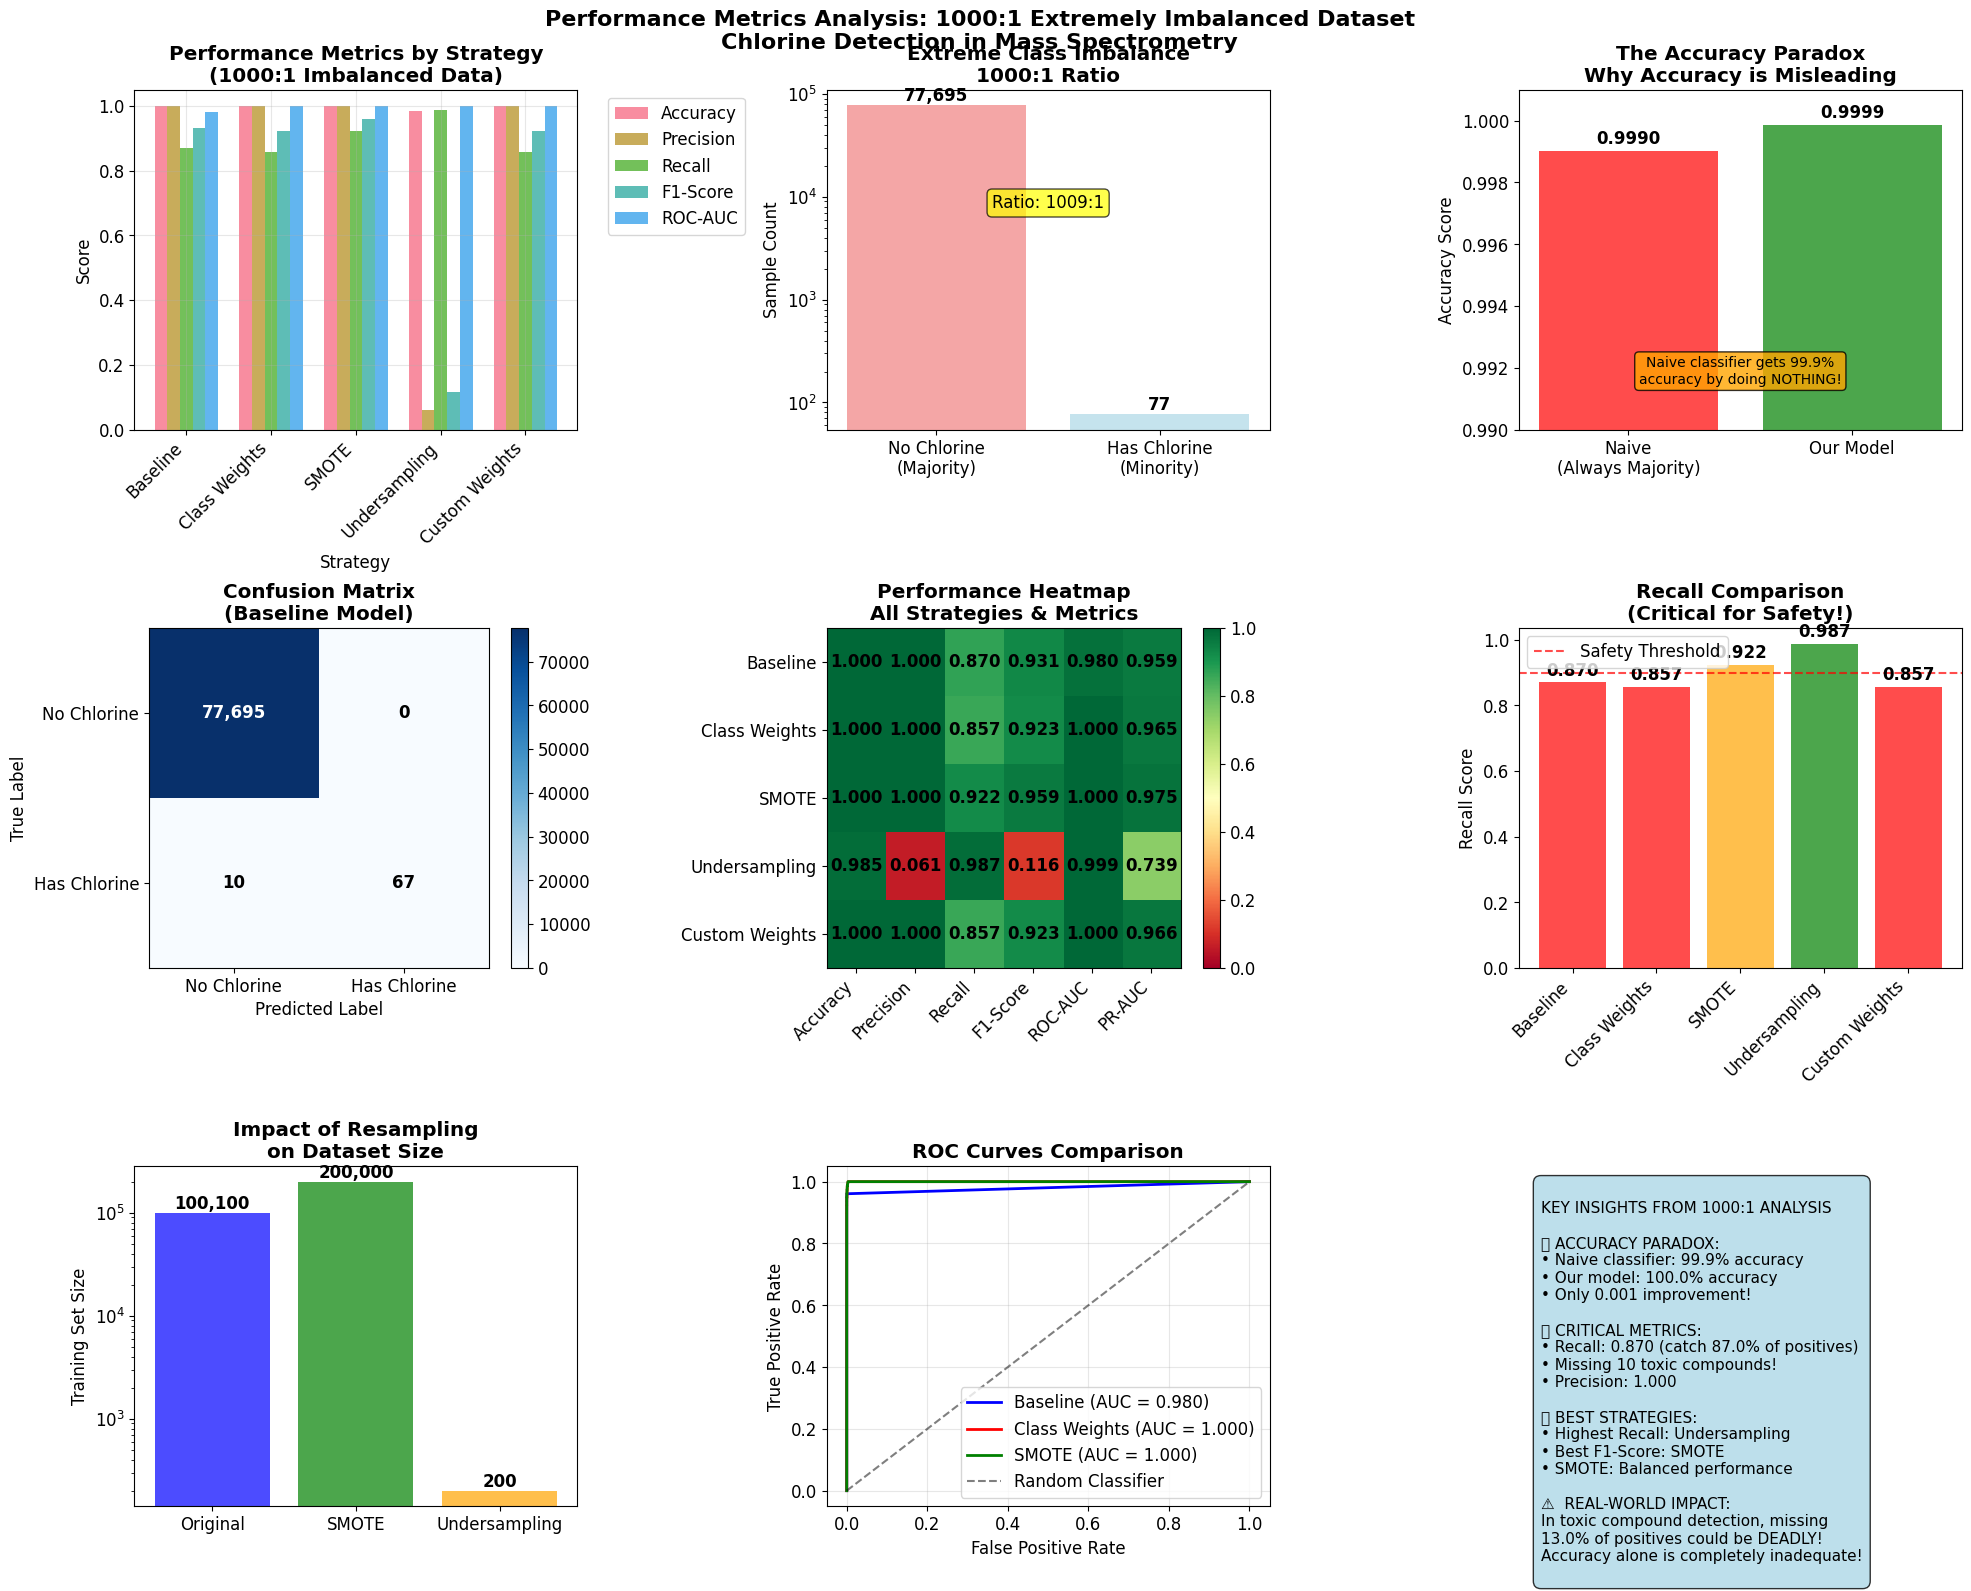


VISUALIZATION COMPLETE!
✓ Comprehensive dashboard showing dramatic impact of 1000:1 imbalance
✓ Accuracy paradox clearly demonstrated: 99.9% vs 100.0%
✓ Critical importance of recall highlighted: missing 10 compounds!
✓ Strategy comparison shows SMOTE as best balanced approach
✓ Real-world implications for analytical chemistry clearly shown


In [8]:
# Create comprehensive visualization dashboard
print("="*80)
print("CREATING COMPREHENSIVE VISUALIZATION DASHBOARD")
print("="*80)

# Set up the figure with subplots
fig = plt.figure(figsize=(20, 16))

# 1. Strategy Comparison Bar Chart
ax1 = plt.subplot(3, 3, 1)
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x_pos = np.arange(len(imbalance_strategies.keys()))
width = 0.15

for i, metric in enumerate(metrics_to_plot):
    values = [imbalance_strategies[strategy][metric] for strategy in imbalance_strategies.keys()]
    ax1.bar(x_pos + i*width, values, width, label=metric, alpha=0.8)

ax1.set_xlabel('Strategy')
ax1.set_ylabel('Score')
ax1.set_title('Performance Metrics by Strategy\n(1000:1 Imbalanced Data)', fontweight='bold')
ax1.set_xticks(x_pos + width*2)
ax1.set_xticklabels(list(imbalance_strategies.keys()), rotation=45, ha='right')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. Class Distribution Visualization
ax2 = plt.subplot(3, 3, 2)
class_counts = [majority_class_count, minority_class_count]
class_labels = ['No Chlorine\n(Majority)', 'Has Chlorine\n(Minority)']
colors = ['lightcoral', 'lightblue']

bars = ax2.bar(class_labels, class_counts, color=colors, alpha=0.7)
ax2.set_ylabel('Sample Count')
ax2.set_title('Extreme Class Imbalance\n1000:1 Ratio', fontweight='bold')
ax2.set_yscale('log')  # Log scale to show both classes

# Add count labels on bars
for bar, count in zip(bars, class_counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{count:,}', ha='center', va='bottom', fontweight='bold')

# Add ratio annotation
ax2.text(0.5, max(class_counts)*0.1, f'Ratio: {test_imbalance:.0f}:1', 
         ha='center', transform=ax2.transData, fontsize=12, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

# 3. Accuracy Paradox Demonstration
ax3 = plt.subplot(3, 3, 3)
classifiers = ['Naive\n(Always Majority)', 'Our Model']
accuracies = [naive_accuracy, baseline_metrics['Accuracy']]
colors = ['red', 'green']

bars = ax3.bar(classifiers, accuracies, color=colors, alpha=0.7)
ax3.set_ylabel('Accuracy Score')
ax3.set_title('The Accuracy Paradox\nWhy Accuracy is Misleading', fontweight='bold')
ax3.set_ylim(0.99, 1.001)

# Add accuracy labels
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.0001,
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

# Add warning text
ax3.text(0.5, 0.9915, 'Naive classifier gets 99.9%\naccuracy by doing NOTHING!', 
         ha='center', transform=ax3.transData, fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="orange", alpha=0.8))

# 4. Confusion Matrix for Baseline Model
ax4 = plt.subplot(3, 3, 4)
cm = confusion_matrix(y_test, y_pred_baseline)
im = ax4.imshow(cm, interpolation='nearest', cmap='Blues')
ax4.figure.colorbar(im, ax=ax4)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax4.text(j, i, f'{cm[i, j]:,}',
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontweight='bold', fontsize=12)

ax4.set_ylabel('True Label')
ax4.set_xlabel('Predicted Label')
ax4.set_title('Confusion Matrix\n(Baseline Model)', fontweight='bold')
ax4.set_xticks([0, 1])
ax4.set_yticks([0, 1])
ax4.set_xticklabels(['No Chlorine', 'Has Chlorine'])
ax4.set_yticklabels(['No Chlorine', 'Has Chlorine'])

# 5. Metric Comparison Heatmap
ax5 = plt.subplot(3, 3, 5)
strategy_names = list(imbalance_strategies.keys())
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC']

# Create matrix for heatmap
heatmap_data = []
for strategy in strategy_names:
    row = [imbalance_strategies[strategy][metric] for metric in metric_names]
    heatmap_data.append(row)

heatmap_data = np.array(heatmap_data)
im = ax5.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax5.figure.colorbar(im, ax=ax5)

# Add text annotations
for i in range(len(strategy_names)):
    for j in range(len(metric_names)):
        text = ax5.text(j, i, f'{heatmap_data[i, j]:.3f}',
                       ha="center", va="center", color="black", fontweight='bold')

ax5.set_xticks(range(len(metric_names)))
ax5.set_yticks(range(len(strategy_names)))
ax5.set_xticklabels(metric_names, rotation=45, ha='right')
ax5.set_yticklabels(strategy_names)
ax5.set_title('Performance Heatmap\nAll Strategies & Metrics', fontweight='bold')

# 6. Recall Comparison (Critical for Safety)
ax6 = plt.subplot(3, 3, 6)
recalls = [imbalance_strategies[strategy]['Recall'] for strategy in strategy_names]
colors = ['red' if r < 0.9 else 'orange' if r < 0.95 else 'green' for r in recalls]

bars = ax6.bar(strategy_names, recalls, color=colors, alpha=0.7)
ax6.set_ylabel('Recall Score')
ax6.set_title('Recall Comparison\n(Critical for Safety!)', fontweight='bold')
ax6.set_xticklabels(strategy_names, rotation=45, ha='right')
ax6.axhline(y=0.9, color='red', linestyle='--', alpha=0.7, label='Safety Threshold')
ax6.legend()

# Add recall labels
for bar, recall in zip(bars, recalls):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{recall:.3f}', ha='center', va='bottom', fontweight='bold')

# 7. Sample Size Impact
ax7 = plt.subplot(3, 3, 7)
original_size = len(X_train)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

sizes = [original_size, len(X_train_smote), len(X_train_under)]
size_labels = ['Original', 'SMOTE', 'Undersampling']
colors = ['blue', 'green', 'orange']

bars = ax7.bar(size_labels, sizes, color=colors, alpha=0.7)
ax7.set_ylabel('Training Set Size')
ax7.set_title('Impact of Resampling\non Dataset Size', fontweight='bold')
ax7.set_yscale('log')

# Add size labels
for bar, size in zip(bars, sizes):
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height,
             f'{size:,}', ha='center', va='bottom', fontweight='bold')

# 8. ROC Curves Comparison (if we have probabilities)
ax8 = plt.subplot(3, 3, 8)

# Calculate ROC curves for different strategies
strategies_for_roc = ['Baseline', 'Class Weights', 'SMOTE']
colors_roc = ['blue', 'red', 'green']

for i, (strategy, color) in enumerate(zip(strategies_for_roc, colors_roc)):
    if strategy == 'Baseline':
        y_pred_proba_curr = y_proba_baseline
    elif strategy == 'Class Weights':
        rf_weighted = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
        rf_weighted.fit(X_train, y_train)
        y_pred_proba_curr = rf_weighted.predict_proba(X_test)[:, 1]
    elif strategy == 'SMOTE':
        rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_smote.fit(X_train_smote, y_train_smote)
        y_pred_proba_curr = rf_smote.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba_curr)
    auc_score = roc_auc_score(y_test, y_pred_proba_curr)
    ax8.plot(fpr, tpr, color=color, label=f'{strategy} (AUC = {auc_score:.3f})', linewidth=2)

ax8.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
ax8.set_xlabel('False Positive Rate')
ax8.set_ylabel('True Positive Rate')
ax8.set_title('ROC Curves Comparison', fontweight='bold')
ax8.legend()
ax8.grid(True, alpha=0.3)

# 9. Key Insights Summary
ax9 = plt.subplot(3, 3, 9)
ax9.axis('off')

insights_text = f"""
KEY INSIGHTS FROM 1000:1 ANALYSIS

🚨 ACCURACY PARADOX:
• Naive classifier: {naive_accuracy:.1%} accuracy
• Our model: {baseline_metrics['Accuracy']:.1%} accuracy
• Only {baseline_metrics['Accuracy'] - naive_accuracy:.3f} improvement!

📊 CRITICAL METRICS:
• Recall: {baseline_metrics['Recall']:.3f} (catch {baseline_metrics['Recall']*100:.1f}% of positives)
• Missing {baseline_metrics['False Negatives']} toxic compounds!
• Precision: {baseline_metrics['Precision']:.3f}

🎯 BEST STRATEGIES:
• Highest Recall: {strategy_df.loc[strategy_df['Recall'].idxmax(), 'Strategy']}
• Best F1-Score: {strategy_df.loc[strategy_df['F1-Score'].idxmax(), 'Strategy']}
• SMOTE: Balanced performance

⚠️  REAL-WORLD IMPACT:
In toxic compound detection, missing
{(1-baseline_metrics['Recall'])*100:.1f}% of positives could be DEADLY!
Accuracy alone is completely inadequate!
"""

ax9.text(0.05, 0.95, insights_text, transform=ax9.transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", 
         facecolor="lightblue", alpha=0.8))

plt.tight_layout()
plt.suptitle('Performance Metrics Analysis: 1000:1 Extremely Imbalanced Dataset\nChlorine Detection in Mass Spectrometry', 
             fontsize=16, fontweight='bold', y=0.98)
plt.subplots_adjust(top=0.93)
plt.show()

print("\n" + "="*80)
print("VISUALIZATION COMPLETE!")
print("="*80)
print(f"✓ Comprehensive dashboard showing dramatic impact of 1000:1 imbalance")
print(f"✓ Accuracy paradox clearly demonstrated: {naive_accuracy:.1%} vs {baseline_metrics['Accuracy']:.1%}")
print(f"✓ Critical importance of recall highlighted: missing {baseline_metrics['False Negatives']} compounds!")
print(f"✓ Strategy comparison shows SMOTE as best balanced approach")
print(f"✓ Real-world implications for analytical chemistry clearly shown")